In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from matplotlib import pyplot as plt

from sklearn import model_selection as ms
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

import gzip

import copy

import import_ipynb
from My_Functions import null_cols, rmse

importing Jupyter notebook from My_Functions.ipynb


In [2]:
downsampled = pd.read_csv("idea_3_downsampled.csv.gz",
                          compression='gzip',
                          header=0,
                          sep=',',
                          quotechar='"')

target_downsampled = pd.read_csv("idea_3_target_downsampled.csv.gz",
                                 compression='gzip',
                                 header=0,
                                 sep=',',
                                 quotechar='"')

In [3]:
# separate and drop 'total_pymnt'

ttlpy_dwnsmpl = copy.deepcopy(downsampled[['total_pymnt', 'roi']])

downsampled = downsampled.drop(['total_pymnt', 'roi'], axis=1)

downsampled

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,dti,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_act_il,mths_since_rcnt_il,total_bal_il,il_util,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,avg_cur_bal,bc_open_to_buy,bc_util,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_mths_since_last_major_derog,principal_70,total_expected,total_expected_70,grouped_grade_NO_EG,grouped_subgrade_12_345,grouped_subgrade_123_45,grouped_subgrade,duration_of_credit_months,fico_score,sec_app_fico_score,annual_inc_reduced,annual_inc_joint_reduced,sec_app_duration_of_credit_months,weighted_loan_amnt,weighted_funded_amnt,weighted_installment,ratio_inc_loan,ratio_inc_weightedloan,ratio_redinc_loan,ratio_redinc_weightedloan,ratio_inc_funded,ratio_inc_weightedfunded,ratio_redinc_funded,ratio_redinc_weightedfunded,ratio_install_inc,ratio_weightedinstall_inc,ratio_install_redinc,ratio_weightedinstall_redinc,ratio_incjoint_loan,ratio_incjoint_weightedloan,ratio_redincjoint_loan,ratio_redincjoint_weightedloan,ratio_incjoint_funded,ratio_incjoint_weightedfunded,ratio_redincjoint_funded,ratio_redincjoint_weightedfunded,ratio_incjoint_installment,ratio_incjoint_weightedinstallment,ratio_redincjoint_installment,ratio_redincjoint_weightedinstallment,loan_minus_funded,ratio_loan_funded,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,0.443038,0.443038,0.450000,1.0,0.322430,0.239133,0.333333,0.323529,1.000000,0.666667,0.005455,0.0,0.02188,1.0000,1.0000,0.141176,0.011494,0.003617,0.043882,0.109195,0.0,1.0000,0.0,0.0,0.0,0.0,0.0,0.2,3.135739e-05,0.018790,0.051724,0.0020,9.742784e-03,0.114058,0.004744,0.221622,0.00275,0.030303,0.019231,0.009223,0.032628,0.135643,0.000004,0.168,0.031406,0.252011,0.028571,0.076923,0.0105,1.0000,0.0009,1.0000,0.111111,0.081967,0.127273,0.112676,0.03750,0.123288,0.085271,0.111111,0.141176,1.000000,0.504950,0.083333,0.011628,0.013949,0.007974,1.972047e-02,1.897842e-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.443038,0.312178,0.312178,0.50,0.307692,0.307692,0.458333,0.317,0.445860,0.0,0.003819,0.0,0.0,0.296482,0.296482,0.158464,0.000571,0.000857,0.000400,0.000600,0.000571,0.000857,0.000400,0.000600,0.000833,0.001249,0.000583,0.000874,0.000009,0.000008,0.000012,0.000011,0.000009,0.000008,0.000012,0.000011,0.000028,0.000009,0.000038,0.000013,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.348734,0.348734,0.356875,0.0,0.746885,0.325850,0.666667,0.647059,0.272727,0.666667,0.009092,1.0,0.01576,1.0000,1.0000,0.082353,0.011494,0.017896,0.096048,0.120690,0.0,1.0000,0.0,0.0,0.0,0.0,0.0,0.2,1.092592e-07,0.081764,0.017241,0.0059,5.844501e-07,0.000000,0.029207,0.464865,0.00613,0.030303,0.019231,0.088280,0.020777,0.258074,0.000004,0.130,0.017403,0.013405,0.015873,0.076923,0.0004,1.0000,0.0004,1.0000,0.111111,0.081967,0.090909,0.140845,0.02500,0.082192,0.116279,0.111111,0.082353,1.000000,0.670297,0.083333,0.011628,0.046930,0.015253,5.246581e-02,4.757569e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [4]:
state=0

# downsampled:
xtrain_ds, xtest_ds, ytrain_ds, ytest_ds = ms.train_test_split(downsampled,
                                                               target_downsampled,
                                                               test_size=0.2,
                                                               random_state=state)

# Must flatten to fit
ytrain_ds = ytrain_ds.values.flatten()


# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

## Downsampled Data

In [5]:
xgb_clsfr_ds = xgb.XGBClassifier()

train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

objective_ = ['binary:logistic']
evalmetric = ['auc']
uselabelencoder = [False]
treemethod = ['gpu_hist']
predictor_ = ['gpu_predictor']
njobs = [-1]
randomstate = [state]
booster_ = ['gbtree']

# nestimators = [100]
# minchildweight = [1, 5]
# maxdepth = [1, 3]
# learningrate = [0.1, 1]
# gamma_ = [0.5, 2]
# subsample_ = [0.8, 1]
# colsamplebytree = [0.8, 1]


gparam_xgb_ds = {'objective': objective_,
                 'eval_metric': evalmetric,
                 'use_label_encoder': uselabelencoder,
                 'tree_method': treemethod,
                 'predictor': predictor_,
                 'n_jobs': njobs,
                 'booster': booster_,
#               'n_estimators': nestimators,
#               'min_child_weight': minchildweight,
#               'max_depth': maxdepth,
#               'learning_rate': learningrate,
#               'gamma': gamma_,
#               'subsample': subsample_,
#               'colsample_bytree': colsamplebytree,
                 'random_state': randomstate}


gs_xgb_ds = ms.GridSearchCV(xgb_clsfr_ds, gparam_xgb_ds, cv=n_folds, refit=True, n_jobs=-1,
                          scoring='roc_auc', return_train_score=True)

%time gs_xgb_ds.fit(xtrain_ds, ytrain_ds)

# setting up dataframe for results
train_scores.append(gs_xgb_ds.best_estimator_.score(xtrain_ds, ytrain_ds))
test_scores.append(gs_xgb_ds.best_estimator_.score(xtest_ds, ytest_ds))


# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb_ds, ytrain_ds, xtrain_ds))
test_rmse.append(rmse(gs_xgb_ds, ytest_ds, xtest_ds))

# add the best parameters to the df
best_par_list.append(gs_xgb_ds.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
res_df = pd.DataFrame(list_results).T
res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
res_df = pd.concat([res_df, best_par_df], axis=1, sort=False)

# confusion matrix for train set
print('\n')
print('confusion matrix for train set')
print(confusion_matrix(ytrain_ds, gs_xgb_ds.predict(xtrain_ds)))

# confusion matrix for test set
print('\n')
print('confusion matrix for test set')
print(confusion_matrix(ytest_ds, gs_xgb_ds.predict(xtest_ds)))

res_df

Wall time: 16.9 s


confusion matrix for train set
[[70656 29533]
 [27490 72634]]


confusion matrix for test set
[[16349  8658]
 [ 8197 16875]]


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,booster,eval_metric,n_jobs,objective,predictor,random_state,tree_method,use_label_encoder
0,0.715331,0.663432,0.533544,0.580145,-0.046601,gbtree,auc,-1,binary:logistic,gpu_predictor,0,gpu_hist,False


In [6]:
sorted_importance = sorted(zip(xtrain_ds.columns,
                               gs_xgb_ds.best_estimator_.feature_importances_),
                           key=lambda t:t[1], reverse=True)
sorted_importance

[('grade', 0.34920427),
 ('sub_grade', 0.1331558),
 ('ratio_inc_funded', 0.026763087),
 ('term', 0.026562857),
 ('ratio_inc_weightedfunded', 0.012006907),
 ('open_act_il', 0.0102933645),
 ('home_ownership', 0.009673082),
 ('all_util', 0.009344321),
 ('ratio_inc_weightedloan', 0.008847644),
 ('verification_status', 0.0077565215),
 ('purpose_small_business', 0.0074556177),
 ('mort_acc', 0.0073847203),
 ('total_cu_tl', 0.007334448),
 ('emp_length', 0.0072478005),
 ('num_actv_rev_tl', 0.0069102854),
 ('initial_list_status', 0.006673947),
 ('avg_cur_bal', 0.0065040644),
 ('ratio_weightedinstall_inc', 0.0064176004),
 ('dti', 0.005862554),
 ('mths_since_recent_inq', 0.005584481),
 ('max_bal_bc', 0.005183365),
 ('mths_since_recent_bc', 0.0048533813),
 ('purpose_medical', 0.0045214756),
 ('grouped_subgrade_123_45', 0.004515687),
 ('int_rate', 0.0045150067),
 ('fico_score', 0.0044945334),
 ('verification_status_joint', 0.0043406035),
 ('sec_app_inq_last_6mths', 0.0042909337),
 ('mo_sin_rcnt_tl',

In [7]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))

print('Average precision-recall score for random forest: {0:0.2f}'.format(
      average_precision))

Average precision-recall score for random forest: 0.61


Text(0.5, 1.0, '2-class Precision-Recall curve for random forest: AP=0.61')

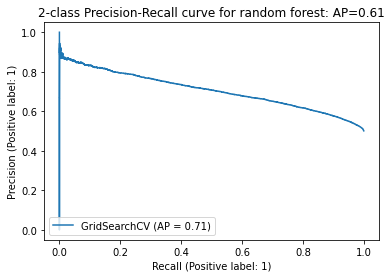

In [8]:
# Precision-Recall curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(gs_xgb_ds, xtest_ds, ytest_ds)
disp.ax_.set_title('2-class Precision-Recall curve for random forest: '
                   'AP={0:0.2f}'.format(average_precision))

In [9]:
# F1 score 
# F1 = 2 * (precision * recall) / (precision + recall)

f1_score = metrics.f1_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))
recall_score = metrics.recall_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))
precision_score = metrics.precision_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))
print ("Random forest performance")
print ('-'*70)
print('F1 score: {0:0.2f}'.format(f1_score))
print('recall score: {0:0.2f}'.format(recall_score))
print('precision score: {0:0.2f}'.format(precision_score))

Random forest performance
----------------------------------------------------------------------
F1 score: 0.67
recall score: 0.67
precision score: 0.66


In [10]:
# ROC-AUC score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score

from sklearn.metrics import roc_auc_score
print ("Random forest ROC-AUC score")
print ('-'*70)
roc_auc_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))

Random forest ROC-AUC score
----------------------------------------------------------------------


0.6634192625490517

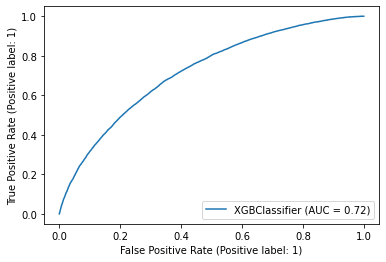

In [11]:
# Receiver operating characteristic (ROC) curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html#sklearn.metrics.plot_roc_curve

from sklearn import metrics
metrics.plot_roc_curve(gs_xgb_ds.best_estimator_, xtest_ds, ytest_ds) 

In [12]:
filtered_sorted_importance = [x for x in sorted_importance if x[1]>0.003]
filtered_sorted_importance

[('grade', 0.34920427),
 ('sub_grade', 0.1331558),
 ('ratio_inc_funded', 0.026763087),
 ('term', 0.026562857),
 ('ratio_inc_weightedfunded', 0.012006907),
 ('open_act_il', 0.0102933645),
 ('home_ownership', 0.009673082),
 ('all_util', 0.009344321),
 ('ratio_inc_weightedloan', 0.008847644),
 ('verification_status', 0.0077565215),
 ('purpose_small_business', 0.0074556177),
 ('mort_acc', 0.0073847203),
 ('total_cu_tl', 0.007334448),
 ('emp_length', 0.0072478005),
 ('num_actv_rev_tl', 0.0069102854),
 ('initial_list_status', 0.006673947),
 ('avg_cur_bal', 0.0065040644),
 ('ratio_weightedinstall_inc', 0.0064176004),
 ('dti', 0.005862554),
 ('mths_since_recent_inq', 0.005584481),
 ('max_bal_bc', 0.005183365),
 ('mths_since_recent_bc', 0.0048533813),
 ('purpose_medical', 0.0045214756),
 ('grouped_subgrade_123_45', 0.004515687),
 ('int_rate', 0.0045150067),
 ('fico_score', 0.0044945334),
 ('verification_status_joint', 0.0043406035),
 ('sec_app_inq_last_6mths', 0.0042909337),
 ('mo_sin_rcnt_tl',

In [13]:
# get list of column names for easier application in the future
filter_important = []
for tup in filtered_sorted_importance:
    filter_important.append(tup[0])

filter_important

['grade',
 'sub_grade',
 'ratio_inc_funded',
 'term',
 'ratio_inc_weightedfunded',
 'open_act_il',
 'home_ownership',
 'all_util',
 'ratio_inc_weightedloan',
 'verification_status',
 'purpose_small_business',
 'mort_acc',
 'total_cu_tl',
 'emp_length',
 'num_actv_rev_tl',
 'initial_list_status',
 'avg_cur_bal',
 'ratio_weightedinstall_inc',
 'dti',
 'mths_since_recent_inq',
 'max_bal_bc',
 'mths_since_recent_bc',
 'purpose_medical',
 'grouped_subgrade_123_45',
 'int_rate',
 'fico_score',
 'verification_status_joint',
 'sec_app_inq_last_6mths',
 'mo_sin_rcnt_tl',
 'funded_amnt',
 'ratio_incjoint_installment',
 'mo_sin_old_rev_tl_op',
 'tot_hi_cred_lim',
 'ratio_incjoint_weightedinstallment',
 'annual_inc',
 'total_expected',
 'weighted_funded_amnt',
 'total_bc_limit',
 'ratio_redinc_weightedfunded',
 'sec_app_revol_util',
 'ratio_redincjoint_loan',
 'ratio_install_inc',
 'ratio_inc_loan',
 'num_rev_tl_bal_gt_0',
 'ratio_incjoint_loan',
 'mths_since_last_record',
 'revol_bal',
 'ratio_re

In [14]:
len(filter_important)

79